### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils
from pathlib import Path
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import distclassipy as dcpy

In [4]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [5]:
unique_metrics = [
    "euclidean",
    "braycurtis",
    "canberra",
    "cityblock",
    "chebyshev",
    "clark",
    "correlation",
    "cosine",
    "hellinger",
    "jaccard",
    "lorentzian",
    "meehl",
    "soergel",
    "wave_hedges",
    "kulczynski",
    "add_chisq",
    "acc",
    "chebyshev_min",
    "divergence",
    "google",
    "jeffreys",
    "kumarjohnson",
    "penroseshape",
    "squared_chisq",
    "squaredchord",
    "squared_euclidean",
    "taneja",
    "topsoe",
    "vicis_symmetric_chisq",
    "vicis_wave_hedges",
]

final_features = [
    "SPM_A_Y",
    "Multiband_period",
    "r-i",
    "Harmonics_phase_4_i",
    "Harmonics_phase_2_r",
    "Power_rate_4",
]

In [6]:
features = pd.read_parquet("data/reduced_balancedfeatures_LATEST.parquet")
features["class"].value_counts()

class
CEP     683
DSCT    683
EB      683
RRL     683
Name: count, dtype: int64

In [7]:
features = features.sample(frac=1)

In [8]:
y_normal_df = features["class"]
# X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)
X_normal_df = features.loc[:, final_features]

In [9]:
other_features_df = pd.read_parquet("data/otherclassobjs_features.parquet")
other_lc_df = pd.read_parquet("data/otherclassobjs.parquet")
other_features_df.index.name = "snid"
other_lc_df.index.name = "snid"
assert (other_lc_df.index == other_features_df.index).all()

In [10]:
X_anom_df = other_features_df.loc[:, X_normal_df.columns].dropna()
X_anom_df = X_anom_df.drop(np.intersect1d(X_anom_df.index, X_normal_df.index))

y_anom_df = other_lc_df.loc[X_anom_df.index]["class"]

In [11]:
X_df = pd.concat([X_normal_df, X_anom_df])
y_df = pd.concat([y_normal_df, y_anom_df])

In [12]:
assert (X_df.index == y_df.index).all()

### 1. Isolation Forest

In [13]:
from sklearn.ensemble import IsolationForest
from scipy import stats

In [14]:
def runif(random_state, X_traindf, X_testdf):
    clf = IsolationForest(
        max_samples=10, contamination="auto", random_state=random_state
    )
    clf.fit(X_traindf)  # , sample_weight=1.0/(Xfixed[:,2,:])**2)
    scores_pred_Norm = clf.decision_function(X_testdf)
    # scores_pred_Norm = clf.score_samples(X)
    # .sample_score(X)

    threshold_Norm = stats.scoreatpercentile(scores_pred_Norm, 100 * 0.1)
    #y_predNorm = clf.predict(X)
    abornmality = -scores_pred_Norm
    iforest_df = pd.DataFrame(
        abornmality, columns=["abnormality"], index=X_testdf.index,
    )  # higher is more abnormal
    # iforest_df.index.name = "sample_num"
    iforest_df = iforest_df.sort_values(by="abnormality", ascending=False)
    return iforest_df.index, iforest_df

In [15]:
ranksIF = []
ranksIDdfs = []
ifseeds = np.random.randint(100, 1000, 3)
for i in ifseeds:
    _ = runif(i, X_traindf=X_normal_df, X_testdf=X_df)
    ranksIF.append(_[0])
    ranksIDdfs.append(_[1])
ranksIF

[Index([ 96837672,  94602724,  88253880, 125103424,  92717442, 130307557,
         34882116,  37691298,   4183976,  34160718,
        ...
        122726080,  47340254,  25574309,  46522535,  55461733,  54311883,
         51885084,  53909322,  59909628,  70781811],
       dtype='int64', name='snid', length=4605),
 Index([ 96837672,  34882116,  94602724,  92717442, 125103424,  83406315,
        132356710,  59245585, 108559610, 101561282,
        ...
         12266070,  77317116, 100486651,  64901941,  25574309,  53358169,
          1283805,  10552144,  13873224,  72631153],
       dtype='int64', name='snid', length=4605),
 Index([ 96837672,  94602724,  34882116, 108559610,  92717442,  34160718,
         63030733, 130307557,  59245585, 114522598,
        ...
        124834816,  32015691,  25574309,  48122575,  49850945,   9828136,
        156074442,  51885084, 143879284,  12266070],
       dtype='int64', name='snid', length=4605)]

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_85690/2281571738.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(


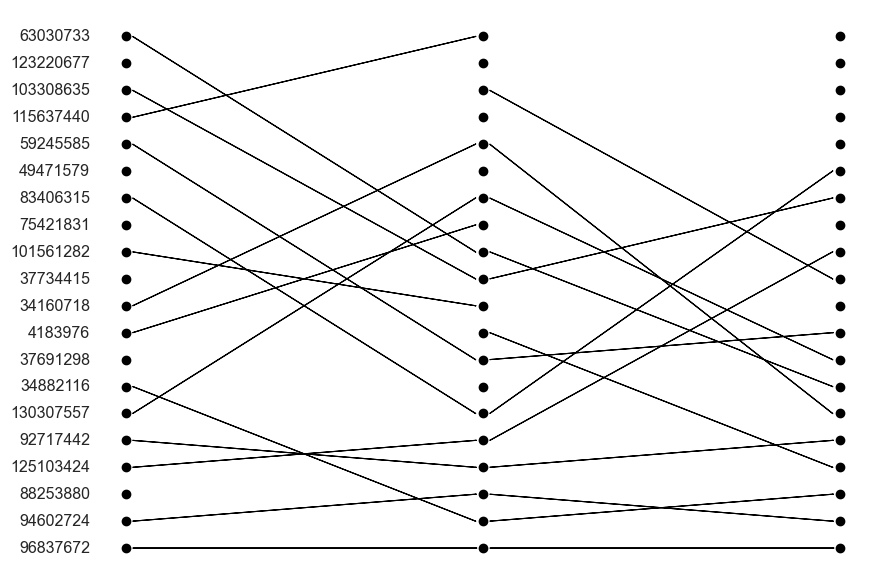

In [16]:
def plotstuff(list_a, list_b, i, ax, arrow_len=0.1):
    # Plot the two columns of equidistant points
    a = list(list_a)
    b = list(list_b)
    a_to_b_indices = [b.index(x) + 1 if x in b else None for x in a]
    for j, target_index in enumerate(a_to_b_indices):
        if target_index is not None:
            ax.arrow(
                0.02 + i,
                j + 1,
                0.96,
                target_index - (j + 1),
                # head_width=0.05 * arrow_len * 10, head_length=0.1 * arrow_len * 10,
                fc="black",
                ec="black",
                length_includes_head=False,
            )


def plot_ranks(rankslists, nsamples=10, labels_offset=0.1):
    """
    Plots two columns of points representing two lists (a and b)
    and draws arrows connecting the rank of elements in 'a' to
    their corresponding position in 'b'.

    Args:
        a (list): The first list of elements.
        b (list): The second list of elements.
        labels_offset (float, optional): Offset for the text labels. Defaults to 0.1.
        arrow_len (float, optional): Length of the arrows. Defaults to 0.1.
    """
    n_items = nsamples
    fig, ax = plt.subplots(
        figsize=(3 * len(rankslists), n_items * 0.3)
    )  # Adjust figure size

    for i in range(len(rankslists)):
        if i == 0:
            a = rankslists[i][:nsamples]
            ax.plot(
                np.ones(n_items),
                np.arange(1, n_items + 1),
                "o",
                markersize=6,
                color="black",
            )
            for j, val in enumerate(a):
                ax.text(1 - labels_offset, j + 1, str(val), ha="right", va="center")
        else:
            b = rankslists[i][:nsamples]
            a = rankslists[i - 1][:nsamples]
            ax.plot(
                np.full(n_items, i + 1),
                np.arange(1, n_items + 1),
                "ro",
                markersize=6,
                color="black",
            )
            for j, val in enumerate(b):
                if not val in b:
                    ax.text(
                        1 - labels_offset + i, j + 1, str(val), ha="right", va="center"
                    )
            plotstuff(a, b, i, ax)

        # Remove axes and labels
        # ax.set_xlim(0, 3)
    ax.set_ylim(0, n_items + 1)
    ax.axis("off")
    plt.tight_layout()

    plt.show()


plot_ranks(ranksIF, nsamples=20)

In [17]:
df=pd.concat(ranksIDdfs,axis=1)
df.columns = ["if1", "if2", "if3"]
for c in df.columns:
    df["quartile_" + c] = pd.qcut(df[c], q=4, labels=False)  # Divides into 4 quantiles
df

,if1,if2,if3,quartile_if1,quartile_if2,quartile_if3
snid,,,,,,
96837672,0.153602,0.155124,0.154811,3,3,3
94602724,0.151189,0.152706,0.151189,3,3,3
88253880,0.146843,0.119747,0.129081,3,3,3
125103424,0.144949,0.147896,0.131143,3,3,3
92717442,0.142569,0.149095,0.140373,3,3,3
...,...,...,...,...,...,...
54311883,-0.082787,-0.057494,-0.072321,0,0,0
51885084,-0.083877,-0.071587,-0.087401,0,0,0
53909322,-0.084936,-0.063280,-0.073858,0,0,0


In [18]:
df["class"] = y_df.loc[df.index]

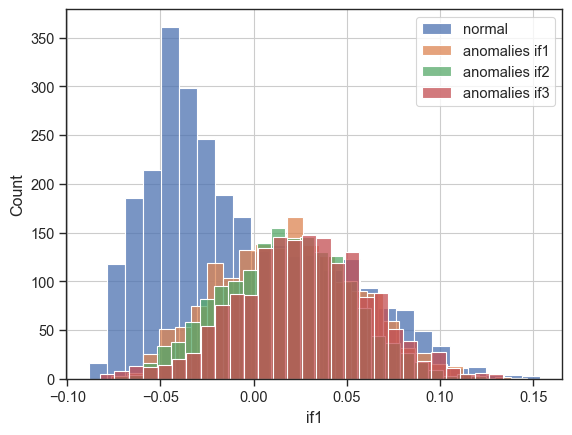

In [19]:
sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"], label="normal")

for i in range(1,4):
    sns.histplot(df[~df["class"].isin(["CEP",
    "DSCT",
    "EB",
    "RRL",]
    )][f"if{i}"], label=f"anomalies if{i}")
    
plt.legend()
plt.show()

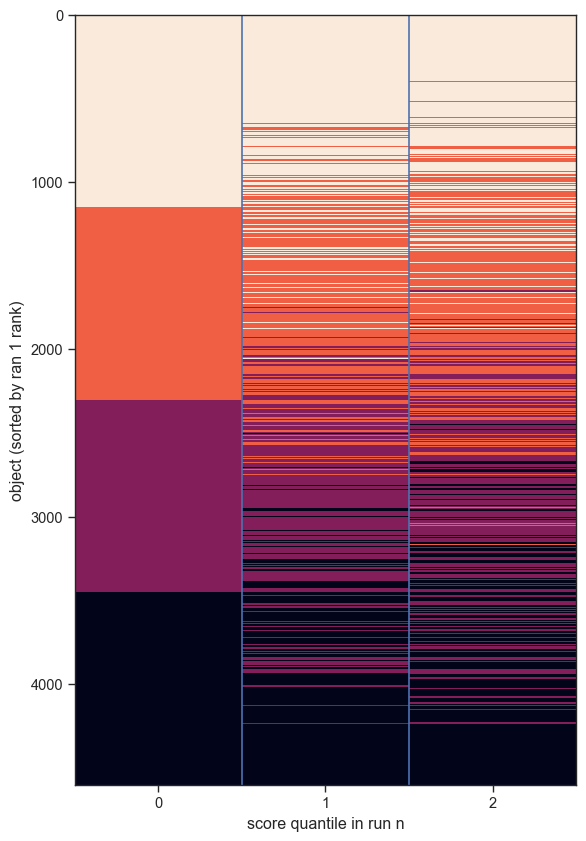

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(df[["quartile_if1", "quartile_if2", "quartile_if3"]], interpolation="none")
ax.set_aspect(0.001)
ax.set_xlabel("score quantile in run n")
ax.set_xticks(range(len(df.columns) - 3-1))
ax.set_ylabel("object (sorted by ran 1 rank)")
plt.grid(None)
ax.axvline(0.5)
ax.axvline(1.5)

In [21]:
top_quantile = df[df["quartile_if1"] == df["quartile_if1"].max()][["quartile_if1", "quartile_if2", "quartile_if3"]]
print(
    f'fraction of run2 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if2"]).sum() / top_quantile.shape[0]}'
)
print(
    f'fraction of run3 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if3"]).sum() / top_quantile.shape[0]}'
)

fraction of run2 top quantile in run 1 0.8575152041702867
fraction of run3 top quantile in run 1 0.8470894874022589


### Distances

In [22]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X_normal_df, y_normal_df)

DistanceMetricClassifier()

In [23]:
dist_df_dict = {}
for metric in tqdm(unique_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X_df, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df["minimum_distance"] = dist_df.min(axis=1)
    dist_df["median_distance"] = dist_df.median(axis=1)

    dist_df.index.name = "sample_num"
    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/30 [00:00<?, ?it/s]

In [24]:
n_metrics = len(unique_metrics)
clusters = np.unique(y_normal_df)
n_clusters = len(clusters)
n_objects = dist_df.shape[0]


print(f"n: {n_objects=}")
print(f"m: {n_metrics=}")
print(f"k: {n_clusters=}")

n: n_objects=4605
m: n_metrics=30
k: n_clusters=4


In [25]:
dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(unique_metrics):
            metric_str = utils.get_metric_name(metric)
            dist_df_arr[i, j, k] = dist_df_dict[metric_str].loc[i, f"{cluster}_dist"]

In [26]:
cluster_aggregates = ["min", "median"]
metric_aggregates = ["min", "p25", "median"]

In [27]:
dist_aggregates = np.zeros((len(dist_df_dict["Euclidean"]), 3, 2))
dist_aggregates.shape

(4605, 3, 2)

In [28]:
dist_df_dict[utils.get_metric_name(metric)]

,CEP_dist,DSCT_dist,EB_dist,RRL_dist,minimum_distance,median_distance
sample_num,,,,,,
0,196.145401,21.275020,22.879637,19.750936,19.750936,21.275020
1,249.154153,8.402903,12.086625,23.182878,8.402903,12.086625
2,91.402863,2.444103,28.202184,12.564333,2.444103,12.564333
3,194.311222,195.537040,191.110240,105.719766,105.719766,191.110240
4,471.031777,20.128267,6.731718,38.858505,6.731718,20.128267
...,...,...,...,...,...,...
4600,478.177294,42.694496,12.551029,56.743045,12.551029,42.694496
4601,43.884191,31.659549,89.576117,12.643754,12.643754,31.659549
4602,72950.534332,2806.710707,117.531116,5764.293674,117.531116,2806.710707


In [29]:
dist_minK_by_M = np.array(
    [
        dist_df_dict[utils.get_metric_name(metric)]["minimum_distance"]
        for i, metric in enumerate(unique_metrics)
    ]
)
dist_medK_by_M = np.array(
    [
        dist_df_dict[utils.get_metric_name(metric)]["median_distance"]
        for i, metric in enumerate(unique_metrics)
    ]
)

In [30]:
dist_aggregates = pd.DataFrame(
    np.concatenate(
        [
            np.percentile(dist_minK_by_M, [0, 0.25, 0.5], axis=0),
            np.percentile(dist_medK_by_M, [0, 0.25, 0.5], axis=0),
        ]
    ).T,
    columns=[k + m for k in ["min", "med"] for m in ["min", "25th", "med"]],
    index=df.index,
)

dist_aggregates = pd.concat([dist_aggregates,df],axis=1).drop(["quartile_if1", "quartile_if2", "quartile_if3"],axis=1)
dist_aggregates

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
96837672,0.016655,0.018037,0.019420,0.068188,0.068460,0.068733,0.153602,0.155124,0.154811,CEP
94602724,0.010289,0.010898,0.011508,0.027755,0.028074,0.028393,0.151189,0.152706,0.151189,CEP
88253880,0.009076,0.009740,0.010404,0.037566,0.039073,0.040581,0.146843,0.119747,0.129081,SNIa-91bg
125103424,0.025149,0.025384,0.025618,0.050349,0.054089,0.057829,0.144949,0.147896,0.131143,CEP
92717442,0.016810,0.017321,0.017833,0.020444,0.021199,0.021953,0.142569,0.149095,0.140373,CEP
...,...,...,...,...,...,...,...,...,...,...
54311883,0.006229,0.020606,0.034982,0.036395,0.075925,0.115455,-0.082787,-0.057494,-0.072321,RRL
51885084,0.008449,0.012505,0.016562,0.008577,0.022998,0.037419,-0.083877,-0.071587,-0.087401,RRL
53909322,0.047611,0.059586,0.071562,0.083204,0.116356,0.149508,-0.084936,-0.063280,-0.073858,RRL


In [31]:
dist_aggregates_ranks = (
    dist_aggregates[['minmin', 'min25th', 'minmed', 'medmin', 'med25th', 'medmed', 'if1',
       'if2', 'if3']].rank(axis=0, ascending=False).astype(int)
)
dist_aggregates_ranks

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
snid,,,,,,,,,
96837672,2158,2422,2525,2327,2607,2830,1,1,1
94602724,2747,3065,3161,3873,4083,4195,2,3,2
88253880,2896,3210,3275,3403,3604,3718,3,27,17
125103424,1579,1917,2136,2916,3082,3168,4,5,12
92717442,2145,2480,2628,4242,4391,4421,5,4,5
...,...,...,...,...,...,...,...,...,...
54311883,3354,2250,1639,3468,2365,1524,4601,4386,4477
51885084,3001,2882,2728,4545,4325,3839,4602,4564,4603
53909322,643,634,634,1378,1082,884,4603,4480,4507


In [32]:
dist_aggregates_ranks.sort_values(by="if1", ascending=False)

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
snid,,,,,,,,,
70781811,2519,2817,2925,3426,3591,3693,4605,4402,4521
59909628,1369,1602,1772,3814,3762,3679,4604,4558,4578
53909322,643,634,634,1378,1082,884,4603,4480,4507
51885084,3001,2882,2728,4545,4325,3839,4602,4564,4603
54311883,3354,2250,1639,3468,2365,1524,4601,4386,4477
...,...,...,...,...,...,...,...,...,...
92717442,2145,2480,2628,4242,4391,4421,5,4,5
125103424,1579,1917,2136,2916,3082,3168,4,5,12
88253880,2896,3210,3275,3403,3604,3718,3,27,17


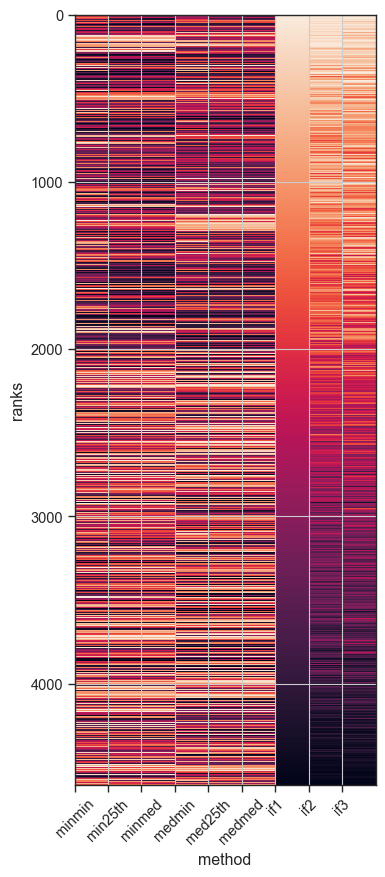

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(
    dist_aggregates_ranks.sort_values(by="if1", ascending=False), interpolation="none"
)
ax.set_aspect(0.005)
ax.set_xticks(np.arange(-0.5, 8.5), labels=dist_aggregates_ranks.columns, rotation=45)
ax.set_ylabel("ranks")
ax.set_xlabel("method")
ax.grid("off")

In [34]:
dist_aggregates[dist_aggregates["minmin"]==0].index

Index([ 96991573, 113316410,   4724826,  91532458,   4603499,  18774334,
        56934698,  69756232,  56496946,  25270002,   6172697, 103707250,
       149698444, 120769130,  17377793,  91661691, 126833962, 128278249,
        57451780,  25192845, 135786849,  83831127,   3677858,  93080393],
      dtype='int64', name='snid')

In [35]:
# add epsilons to zeros
dist_aggregates.loc[dist_aggregates[dist_aggregates["minmin"]==0].index,["minmin"]] += np.finfo(np.float32).eps

In [36]:
dist_aggregates["minmin"].min()

1.1920928955078125e-07

In [37]:
dist_aggregates.min()

minmin          0.0
min25th    0.000055
minmed      0.00011
medmin     0.000403
med25th    0.003477
medmed     0.005965
if1        -0.08831
if2       -0.084707
if3       -0.092617
class           AGN
dtype: object

/Users/sidchaini/miniconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


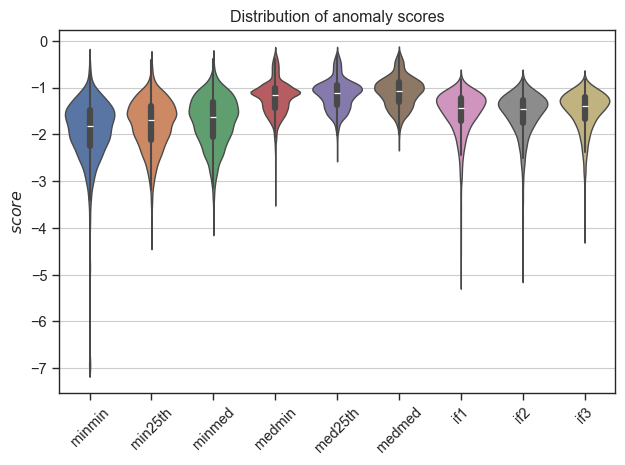

In [38]:
sns.violinplot(
    data=np.log10(dist_aggregates.drop("class",axis=1))
)
plt.title(f"Distribution of anomaly scores")
plt.ylabel(r"$score$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
dist_aggregates.sort_values("minmed",ascending=False)

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
55375376,3.671179e-01,0.383317,0.399516,0.488367,0.510291,0.532214,0.016397,0.023908,0.016215,CEP
142358721,3.616900e-01,0.373519,0.385347,0.485195,0.502615,0.520035,0.007496,0.025047,0.026296,uLens-Binary
39464176,2.978285e-01,0.322059,0.346290,0.495554,0.519768,0.543983,-0.058988,-0.053694,-0.067177,DSCT
48615340,2.974050e-01,0.318114,0.338822,0.442124,0.457857,0.473590,-0.040913,-0.028508,-0.026019,RRL
87498357,3.227316e-01,0.327095,0.331458,0.480622,0.497231,0.513840,0.072782,0.055469,0.081702,Cepheid
...,...,...,...,...,...,...,...,...,...,...
116725101,1.474796e-05,0.000102,0.000189,0.026954,0.027370,0.027786,0.009494,0.002828,0.034359,SNIa-91bg
82592157,1.649061e-04,0.000173,0.000182,0.093535,0.098200,0.102866,0.029369,0.016073,0.021970,EB
62415716,1.687205e-04,0.000175,0.000180,0.047928,0.055408,0.062887,0.069243,0.076062,0.076658,uLens-Binary
